In [507]:
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets, metrics
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from collections import defaultdict
from scipy.stats import pearsonr
from numpy.random import seed, randn
from numpy import percentile

df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_features.csv')
df_train.shape


(113, 22)

In [429]:
df_train['poi'] = df_train['poi'].astype(int)
train_Y = df_train['poi']
train_num = train_Y.shape[0]

names = df_test['name']
df_train = df_train.drop(['name', 'poi'] , axis=1)
df_test = df_test.drop(['name'], axis=1)


In [430]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
def getUsefulData(df):
    
    for dtype, feature in zip(df.dtypes, df.columns):
        if dtype == 'float64' or dtype == 'int64':
            num_features.append(feature)
    #print(f'{len(num_features)} Numeric Features : {num_features}\n')
    df = df[num_features]
    return df

df_train = getUsefulData(df_train)
df_test = df_test[num_features]


In [431]:
#'salary', 'other'，空值用平均值，其餘空值補0
def fillEmpty(df):
    for feature in num_features:  
        mid = np.median(df[~df[feature].isnull()][feature])
        if feature=='salary' or feature=='other':
            df[feature] = df[feature].fillna(df[feature].median())
        else:
            df[feature] = df[feature].fillna(0)
    return df
    
df_train = fillEmpty(df_train)
df_test = fillEmpty(df_test)


In [432]:
#outliner移除
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
#outliers_index=[]        
#outliner_features = ['from_messages', 'from_poi_to_this_person', 'loan_advances',
#                     'other', 'total_payments', 'total_stock_value']
for feature in num_features:
    feature_data = list(df_train[feature])
    data_mean, data_std = mean(feature_data), std(feature_data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in feature_data if x < lower or x > upper]
 
    #用中位數取代
    '''
    mid = np.median(df_train[~df_train[feature].isnull()][feature])
    for outlier in outliers:
        df_train[feature].replace({outlier: mid}, inplace = True)
    '''

    keep_indexs = (df_train[feature]> lower) & (df_train[feature]< upper)
    df_train = df_train[keep_indexs]
    train_Y = train_Y[keep_indexs]
    
    '''
    print (feature)
    print('Identified outliers: %d' % len(outliers))
    print ("outliers: " .format(),  outliers)
    print ("\n")
    '''


In [433]:
#標準化
#scaler = StandardScaler()                                               #z_transform
scaler = MinMaxScaler() 
scaler.fit(df_train)

df_train = pd.DataFrame(data=scaler.transform(df_train), columns=df_train.columns, index=df_train.index)
df_test = pd.DataFrame(data=scaler.transform(df_test), columns=df_test.columns, index=df_test.index)



'''
def min_max_normalize(x):
    x = (( (x - min(x)) / ( max(x) - min(x) ) ) - 0.5) * 2
    return x

def standard_normalize(x):
    x = ( (x - min(x)) / ( max(x) - min(x) ) )
    return x

def z_transform(x):
    x = ( (x - np.mean(x)) / (np.std(x)) )
    return x

for feature in df_train.columns: 
    df_train[feature] = standard_normalize(df_train[feature])
    
for feature in df_test.columns: 
    df_test[feature] = standard_normalize(df_test[feature])
'''


'\ndef min_max_normalize(x):\n    x = (( (x - min(x)) / ( max(x) - min(x) ) ) - 0.5) * 2\n    return x\n\ndef standard_normalize(x):\n    x = ( (x - min(x)) / ( max(x) - min(x) ) )\n    return x\n\ndef z_transform(x):\n    x = ( (x - np.mean(x)) / (np.std(x)) )\n    return x\n\nfor feature in df_train.columns: \n    df_train[feature] = standard_normalize(df_train[feature])\n    \nfor feature in df_test.columns: \n    df_test[feature] = standard_normalize(df_test[feature])\n'

In [434]:
#新增欄位
def addFeatures(df):   
    #deferral_payments: 終止僱傭遞延補償
    #deferred_income: 非僱員董事在遞延薪酬安排下遞延的薪酬
    #df['deferred_loss'] = df['deferral_payments'] - df['deferred_income']
    
    #expenses: 業務費用的報銷
    #director_fees: 現金支付和/或股票授予的價值，以代替向非僱員董事支付的現金。
    #df['director_fees+expenses'] = df['director_fees'] + df['expenses']
    
    #restricted_stock_deferred: 
    #df['director_fees+restricted_stock_deferred'] = df['director_fees'] + df['restricted_stock_deferred']
    
    df["total_payments"] = df["salary"] + df["bonus"] + df["long_term_incentive"] + \
                           df["deferred_income"] + df["deferral_payments"] + df["loan_advances"] + \
                           df["other"] + df["expenses"] + df["director_fees"]
        
    df["total_stock_value"] = df["exercised_stock_options"] + df["restricted_stock"] + \
                              df["restricted_stock_deferred"]        
    return df

df_train = addFeatures(df_train)
df_test = addFeatures(df_test)
num_features.append('total_payments')
num_features.append('total_stock_value')

#df_train['incentive_ontime'] = df_train['deferred_income'] - df_train['long_term_incentive']
#df_train['loss'] = df_train['total_payments'] - df_train['bonus']


In [497]:
trainX, valX, trainY, valY = train_test_split(df_train, train_Y, test_size=0.3, random_state=42)
valX



,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
11,0.560,0.339664,0.828569,0.000000,0.199620,0.261941,0.077286,0.171569,0.979592,0.0,0.000000,0.002147,0.127925,0.777059,0.632210,0.470808,0.423469,2.624531,1.104605
100,0.000,0.109767,1.000000,1.000000,0.000000,0.817001,0.000000,0.000000,0.000000,0.0,0.000000,0.057719,0.000000,0.777059,0.640572,0.000000,0.000000,3.625059,0.777059
28,0.056,0.109767,1.000000,0.000000,0.000000,0.221734,0.013195,0.049020,0.061224,0.0,0.000000,0.000851,0.000000,0.777059,0.536085,0.042665,0.056122,1.924437,0.777059
3,0.640,0.109767,1.000000,0.000000,0.000000,0.930064,0.000000,0.000000,0.000000,0.0,0.434389,1.000000,0.444249,0.777059,0.547342,0.000000,0.000000,4.661562,1.221308
45,0.280,0.109767,0.313026,0.000000,0.596984,0.618437,0.000000,0.000000,0.000000,0.0,0.000000,0.014280,0.806563,0.777059,0.365427,0.000000,0.000000,1.700937,2.180606
82,0.000,0.109767,1.000000,0.000000,0.092162,0.000000,0.032045,0.171569,0.102041,0.0,0.000000,0.057719,0.163906,0.777059,0.640572,0.220434,0.229273,1.808058,1.033127
19,0.800,0.109767,1.000000,0.000000,0.000000,0.000000,0.059378,0.328431,0.285714,0.0,1.000000,0.003395,0.162598,0.777059,0.715883,1.000000,0.899872,3.629044,0.939657
55,0.000,0.109767,1.000000,0.000000,0.198296,0.093625,0.000000,0.000000,0.000000,0.0,0.000000,0.057719,0.392017,0.777059,0.521014,0.000000,0.000000,1.782125,1.367373
21,0.000,0.109767,1.000000,0.000000,0.642912,0.148279,0.000000,0.000000,0.000000,0.0,0.097907,0.000192,0.920497,0.777059,0.106348,0.000000,0.000000,1.462493,2.340468
89,0.280,0.109767,1.000000,0.000000,0.081113,0.187928,0.015080,0.004902,0.163265,0.0,0.401050,0.314504,0.431505,0.777059,0.461614,0.270584,0.298469,2.754861,1.289677


In [478]:
#train_X = df_train
test_X = df_test

# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
lr = LogisticRegression(tol=0.001, penalty='l2', fit_intercept=True, C=1.0)

gdbt = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=250,
                                  max_depth=6, learning_rate=0.03)

dt = DecisionTreeClassifier(criterion = "gini", max_depth=None, min_samples_split=2, min_samples_leaf=1)


rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=6, bootstrap=True)


In [510]:
# 設定要訓練的超參數組合
n_estimators = [50, 100, 150]
#min_samples_split = [2, 4, 6, 8]
#min_samples_leaf = [1, 2, 3, 4]
#bootstrap = ['True', 'False']
max_depth = [1, 3, 5, 10]

param_grid = dict(n_estimators=n_estimators, 
                  max_depth=max_depth)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(rf, param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
#random_search = RandomizedSearchCV(rf, param_grid, scoring="accuracy", n_jobs=-1, verbose=1)



# 開始搜尋最佳參數
grid_result = grid_search.fit(train_X, train_Y)
#random_result = random_search.fit(train_X, train_Y)
#print (grid_result)
#print (random_result)
print("Best grid_result Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#print("Best random_result Accuracy: %f using %s" % (random_result.best_score_, grid_result.best_params_))



rf_bestparam = RandomForestClassifier(n_estimators = random_result.best_params_['n_estimators'],
                                      min_samples_split = 2, 
                                      min_samples_leaf = 1,
                                      max_features = 'sqrt',
                                      max_depth = random_result.best_params_['max_depth'],
                                      bootstrap = True)


                                    

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best grid_result Accuracy: 0.944762 using {'max_depth': 10, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.8s finished


In [511]:
# 隨機森林
rf_bestparam.fit(train_X, train_Y)
rf_pred = rf_bestparam.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': names, 'poi': rf_pred})
#sub.to_csv('submit_rf.csv', index=False)

print(cross_val_score(rf_bestparam,valX,valY,cv=10).mean())
rf_pred

0.9333333333333332


array([0.61, 0.46, 0.35, 0.54, 0.39, 0.32, 0.61, 0.  , 0.29, 0.  , 0.3 ,
       0.  , 0.01, 0.  , 0.32, 0.  , 0.03, 0.13, 0.39, 0.01, 0.7 , 0.52,
       0.09, 0.  , 0.  , 0.03, 0.  , 0.  , 0.16, 0.48, 0.02, 0.03, 0.81])

In [499]:
# 邏輯迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': names, 'poi': lr_pred})
#sub.to_csv('submit_lr.csv', index=False) 
cross_val_score(lr,valX,valY,cv=10).mean()


0.9333333333333332

In [500]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': names, 'poi': gdbt_pred})
#sub.to_csv('submit_gdbt.csv', index=False) 
cross_val_score(gdbt,valX,valY,cv=10).mean()


0.9333333333333332

In [501]:
#決策樹預測檔
dt.fit(train_X, train_Y)
dt_pred = dt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': names, 'poi': dt_pred})
#sub.to_csv('submit_dt.csv', index=False)
cross_val_score(dt,train_X,train_Y,cv=10).mean()


0.9035714285714285

In [ ]:
#####################################################################

In [171]:
# 隨機森林預測檔
rf.fit(train_X, train_Y)

feats = pd.Series(data=rf.feature_importances_, index=df_train.columns)
feats = feats.sort_values(ascending=False)
print (feats)

high_feature = list(feats[:18].index)
train_X = rf.fit(df_train[high_feature], train_Y)


rf_pred = rf.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': names, 'poi': rf_pred})
#sub.to_csv('submit_rf.csv', index=False) 
cross_val_score(rf,train_X,train_Y,cv=10).mean()


#clf.fit(x_train, y_train)
#y_pred = clf.predict(x_test)


expenses                                   0.194668
shared_receipt_with_poi                    0.118491
from_this_person_to_poi                    0.082414
bonus                                      0.081641
other                                      0.080910
director_fees+expenses                     0.078119
from_poi_to_this_person                    0.059019
total_payments                             0.049667
from_messages                              0.036360
total_stock_value                          0.034375
restricted_stock                           0.031398
salary                                     0.030933
long_term_incentive                        0.026100
to_messages                                0.020338
exercised_stock_options                    0.020117
deferred_loss                              0.017739
deferral_payments                          0.016568
deferred_income                            0.013772
director_fees+restricted_stock_deferred    0.007370
loan_advance

ValueError: Number of features of the model must match the input. Model n_features is 18 and input n_features is 22 

In [259]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(train_X, train_Y)
xgb.score(train_X, train_Y)


XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/aliceliao/opt/anaconda3/envs/ML100Days/lib/python3.7/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/aliceliao/opt/anaconda3/envs/ML100Days/lib/python3.7/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


In [379]:
import numpy as np
from scipy.stats import pearsonr
np.random.seed(0)
size = 300
x = np.random.normal(0, 1, size)
print("Lower noise", pearsonr(x, x + np.random.normal(0, 1, size)))
print("Higher noise", pearsonr(x, x + np.random.normal(0, 10, size)))

Lower noise (0.7182483686213841, 7.324017312998504e-49)
Higher noise (0.05796429207933815, 0.31700993885325246)


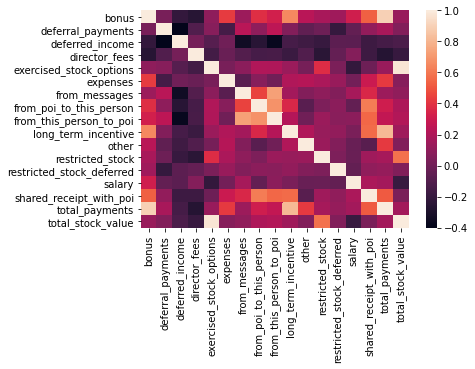

In [373]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_train.corr()
sns.heatmap(corr)
plt.show()


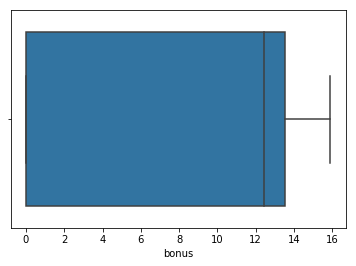

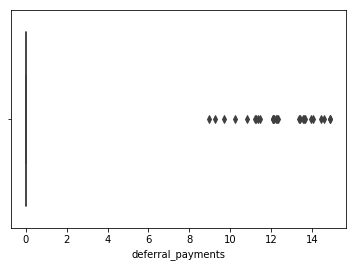

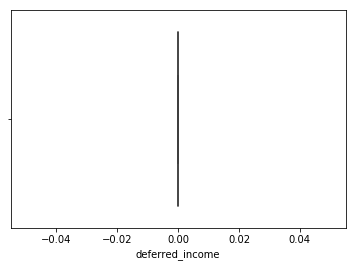

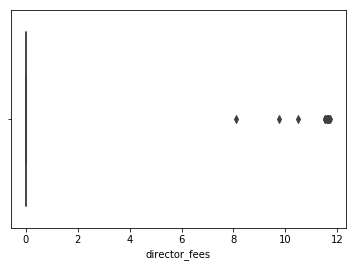

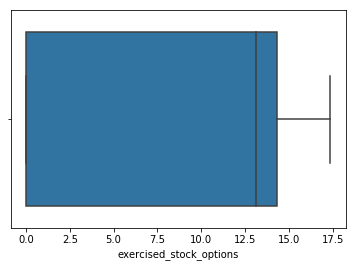

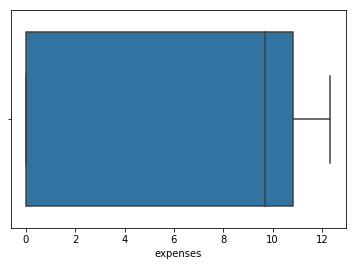

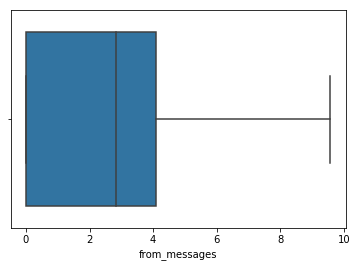

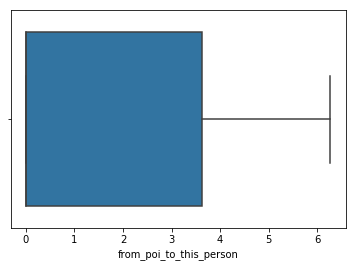

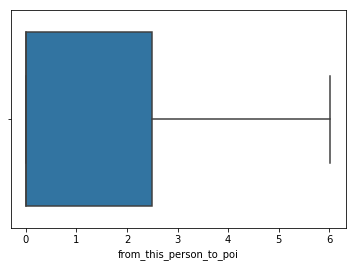

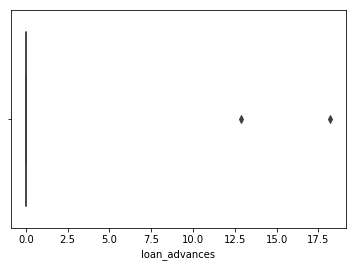

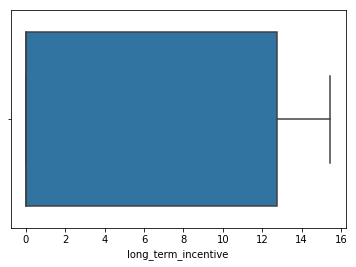

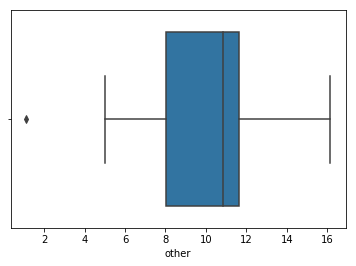

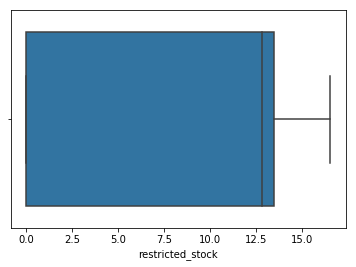

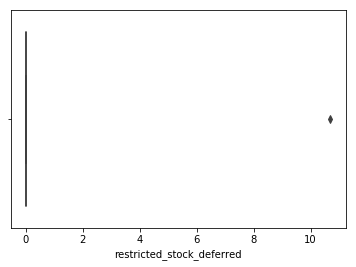

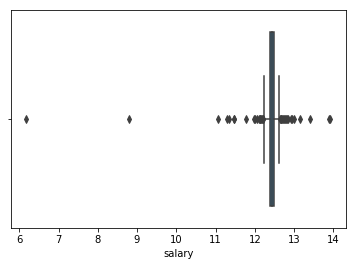

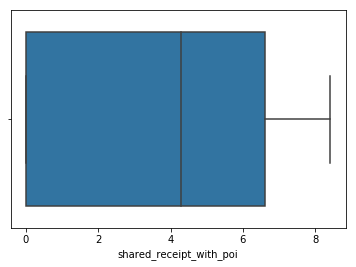

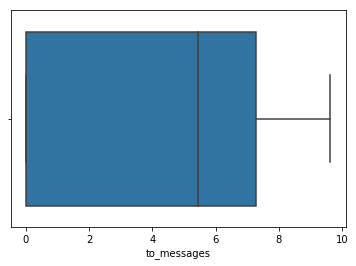

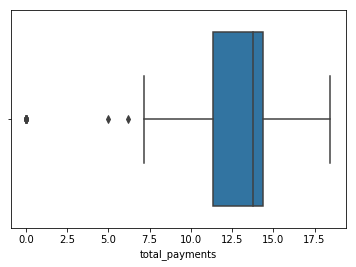

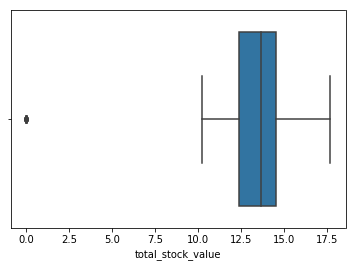

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
for feature in num_features:
    df_train[feature] = np.log1p(df_train[feature])
    sns.boxplot(x=df_train[feature])
    plt.show()
    

count    72.000000
mean      0.443118
std       0.472716
min       0.000000
25%       0.000000
50%       0.000000
75%       0.947718
max       1.000000
Name: bonus, dtype: float64


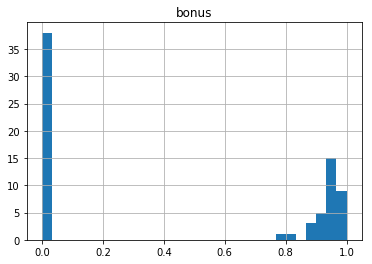

count    71.000000
mean      0.171204
std       0.350541
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: deferral_payments, dtype: float64


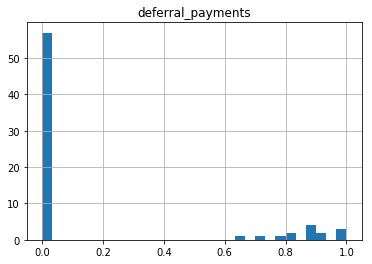

count    55.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: deferred_income, dtype: float64


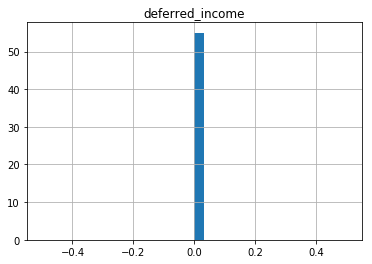

count    72.000000
mean      0.104478
std       0.299652
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: director_fees, dtype: float64


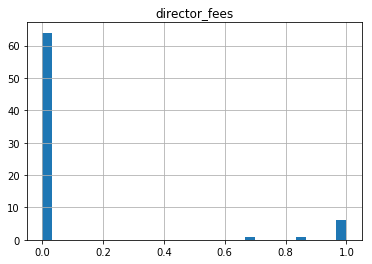

count    72.000000
mean      0.565427
std       0.399117
min       0.000000
25%       0.000000
50%       0.785443
75%       0.852269
max       1.000000
Name: exercised_stock_options, dtype: float64


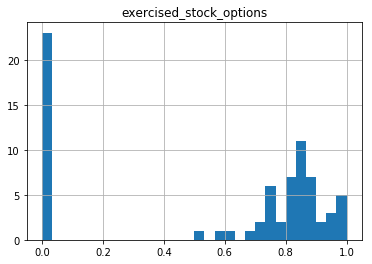

count    72.000000
mean      0.477848
std       0.441283
min       0.000000
25%       0.000000
50%       0.655670
75%       0.914840
max       1.000000
Name: expenses, dtype: float64


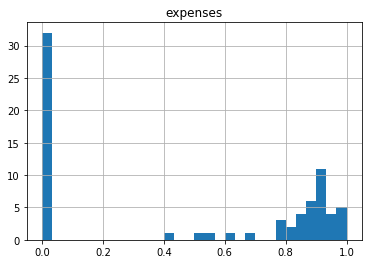

count    72.000000
mean      0.283411
std       0.288702
min       0.000000
25%       0.000000
50%       0.368109
75%       0.528435
max       1.000000
Name: from_messages, dtype: float64


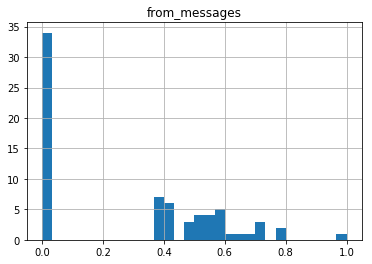

count    72.000000
mean      0.252341
std       0.326379
min       0.000000
25%       0.000000
50%       0.000000
75%       0.550236
max       1.000000
Name: from_poi_to_this_person, dtype: float64


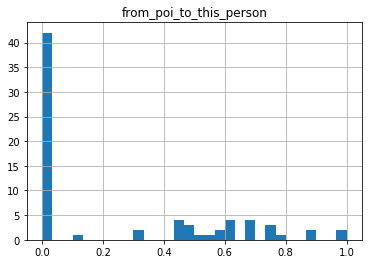

count    72.000000
mean      0.202879
std       0.307772
min       0.000000
25%       0.000000
50%       0.000000
75%       0.411408
max       1.000000
Name: from_this_person_to_poi, dtype: float64


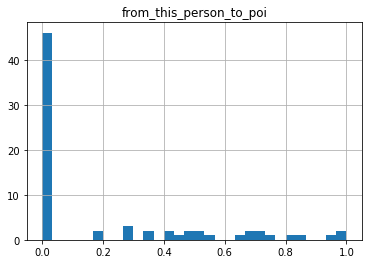

count    72.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: loan_advances, dtype: float64


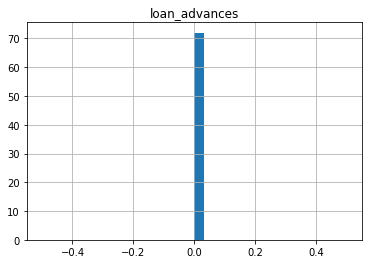

count    72.000000
mean      0.359513
std       0.442062
min       0.000000
25%       0.000000
50%       0.000000
75%       0.881810
max       1.000000
Name: long_term_incentive, dtype: float64


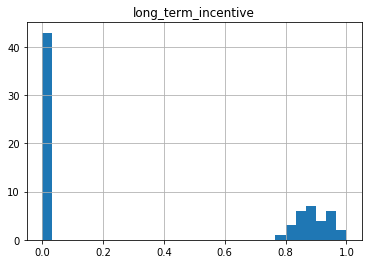

count    72.000000
mean      0.712893
std       0.191969
min       0.000000
25%       0.634890
50%       0.773998
75%       0.773998
max       1.000000
Name: other, dtype: float64


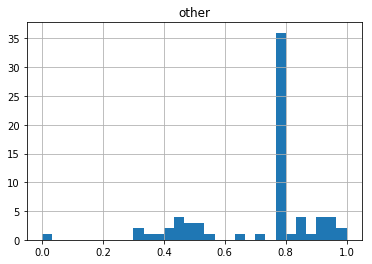

count    72.000000
mean      0.622933
std       0.405504
min       0.000000
25%       0.000000
50%       0.843095
75%       0.896435
max       1.000000
Name: restricted_stock, dtype: float64


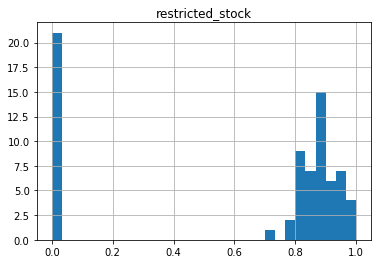

count    68.000000
mean      0.014706
std       0.121268
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: restricted_stock_deferred, dtype: float64


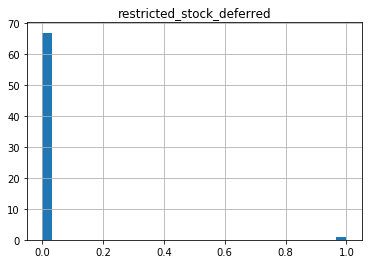

count    72.000000
mean      0.750221
std       0.164950
min       0.000000
25%       0.763542
50%       0.796916
75%       0.796916
max       1.000000
Name: salary, dtype: float64


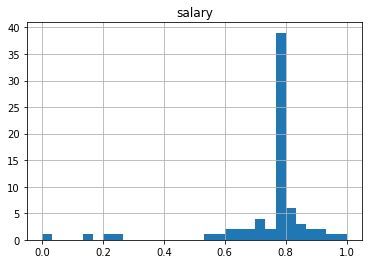

count    72.000000
mean      0.379127
std       0.391690
min       0.000000
25%       0.000000
50%       0.314464
75%       0.782649
max       1.000000
Name: shared_receipt_with_poi, dtype: float64


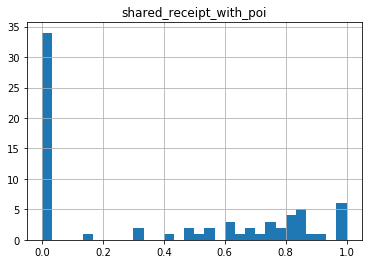

count    72.000000
mean      0.432906
std       0.421841
min       0.000000
25%       0.000000
50%       0.580872
75%       0.828861
max       1.000000
Name: to_messages, dtype: float64


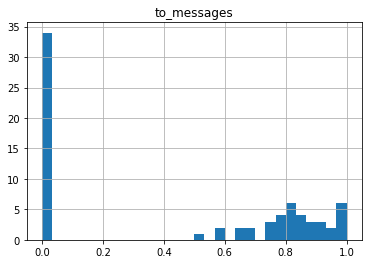

count    54.000000
mean      2.891261
std       1.132020
min       1.570914
25%       1.570914
50%       2.696944
75%       3.771049
max       5.065378
Name: total_payments, dtype: float64


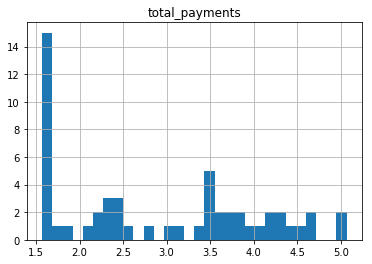

count    68.000000
mean      1.187374
std       0.644214
min       0.000000
25%       0.805229
50%       1.466910
75%       1.730522
max       1.966580
Name: total_stock_value, dtype: float64


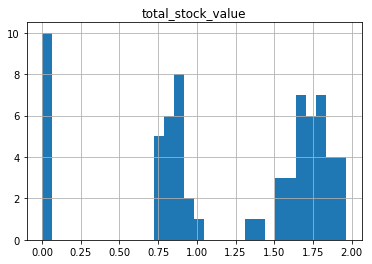

count    54.000000
mean      2.891261
std       1.132020
min       1.570914
25%       1.570914
50%       2.696944
75%       3.771049
max       5.065378
Name: total_payments, dtype: float64


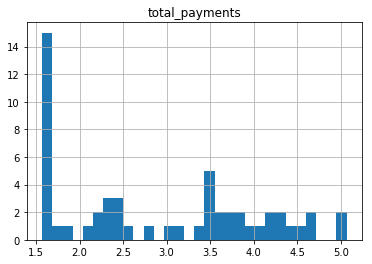

count    68.000000
mean      1.187374
std       0.644214
min       0.000000
25%       0.805229
50%       1.466910
75%       1.730522
max       1.966580
Name: total_stock_value, dtype: float64


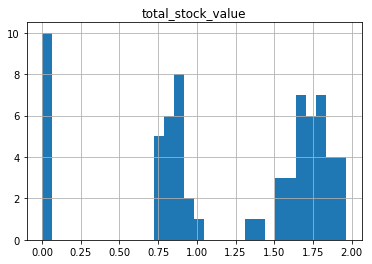

In [389]:
import matplotlib.pyplot as plt

for col in num_features:
    #plt.hist(df[col], 30)
    print (df_train[col].describe())
    df_train[col].hist(bins=30)
    plt.title(col)
    plt.show()



In [176]:
'''
#四分位距移除outliner
for feature in num_features:
    print (feature + ":")
    feature_data = list(df_train[feature])
    #print (feature_data)
    q25, q75 = percentile(feature_data, 25), percentile(feature_data, 75)
    iqr = q75 - q25
    #print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    
    # identify outliers
    outliers = [x for x in feature_data if x < lower or x > upper]
    #print('Identified outliers: %d' % len(outliers))
    
    # remove outliers
    outliers_removed = [x for x in feature_data if x >= lower and x <= upper]
    #print('Non-outlier observations: %d' % len(outliers_removed))
    
    #用中位數取代
    #mid = np.median(df_train[~df_train[feature].isnull()][feature])
    mid = np.median(df_train[feature])
    for outlier in outliers:
        df_train[feature].replace({outlier: mid}, inplace = True)
        
    #keep_indexs = (df_train[feature]>= lower) & (df_train[feature]<= upper)
    #df_train = df_train[keep_indexs]
    #train_Y = train_Y[keep_indexs]
print (df_train.shape)

'''

'\n#四分位距移除outliner\nfor feature in num_features:\n    print (feature + ":")\n    feature_data = list(df_train[feature])\n    #print (feature_data)\n    q25, q75 = percentile(feature_data, 25), percentile(feature_data, 75)\n    iqr = q75 - q25\n    #print(\'Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f\' % (q25, q75, iqr))\n    \n    # calculate the outlier cutoff\n    cut_off = iqr * 1.5\n    lower, upper = q25 - cut_off, q75 + cut_off\n    \n    # identify outliers\n    outliers = [x for x in feature_data if x < lower or x > upper]\n    #print(\'Identified outliers: %d\' % len(outliers))\n    \n    # remove outliers\n    outliers_removed = [x for x in feature_data if x >= lower and x <= upper]\n    #print(\'Non-outlier observations: %d\' % len(outliers_removed))\n    \n    #用中位數取代\n    #mid = np.median(df_train[~df_train[feature].isnull()][feature])\n    mid = np.median(df_train[feature])\n    for outlier in outliers:\n        df_train[feature].replace({outlier: mid}, inplace = True)\n 